# TS8 MAI - Filtros digitales

<img src="img/parte1.jpg">

<img src="img/res2.jpg">
<img src="img/res1.jpg">

## Simulacion en pyton

In [12]:
import sympy as sp
import numpy as np
from sympy.abc import s
from IPython.display import display, Math

Vi, Vo, VA, VB = sp.symbols("Vi, Vo, VA, VB")
C,R,L1,L3 = sp.symbols("C,R,L1,L3")

Za = sp.Matrix([[s*L1 + 1/(s*C),1/(s*C)],[1/(s*C),s*L3 + 1/(s*C)]])

Zb = sp.Matrix([[R,R],[R,R]])

Ta = sp.Matrix([[Za[0]/Za[2],Za.det()/Za[2]],[1/Za[2],Za[3]/Za[2]]])

Tb = sp.Matrix([[Zb[0]/Zb[2],Zb.det()/Zb[2]],[1/Zb[2],Zb[3]/Zb[2]]])

Tt = Ta.multiply(Tb) #Hago el producto matricial

num, den = sp.fraction(sp.simplify(sp.expand(1/Tt[0])))

num = sp.Poly(num,s)
den = sp.Poly(den,s)

k = sp.simplify(num.LC() / den.LC())

num = num.monic() #hacemos que el numerador y denominador sean monicos
den = den.monic()

den_coeffs = den.all_coeffs()

tf_final = sp.Mul(k,num/den, evaluate=False)

display(tf_final)


(R/(C*L1*L3))/(s**3 + R*s**2/L3 + R/(C*L1*L3) + s*(L1 + L3)/(C*L1*L3))

Su transferencia sera:

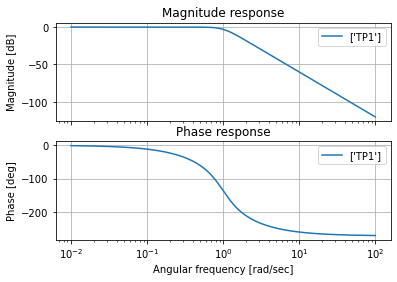

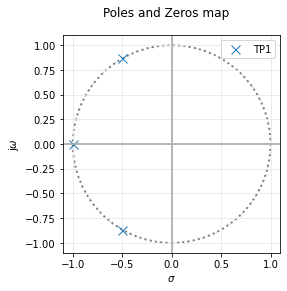

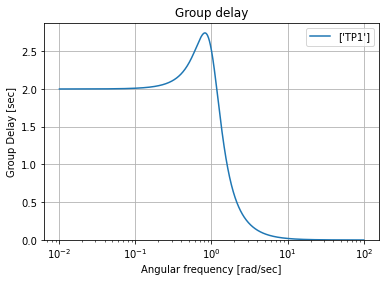

In [18]:
import matplotlib.pyplot as plt
import scipy.signal as sig
from splane import analyze_sys

k= 1

num = np.array([1]) 
den = np.array([1,2,2,1])

tf = sig.TransferFunction(num,den)
    
plt.close('all')
analyze_sys(tf, 'TP1')


Ahora hacemos la verificacion circuital:

<img src="img/simulacion_1.jpg">

Podemos ver que a partir de $\omega = 1$ hay una atenuacion de 60 dB/dec y entonces se verifica la transferencia obtenida.

## TP5 ejercicio 2

Se desea emular digitalmente la característica de un filtro analógico pasa bajos Butterworth de
orden 2, con $f_c =1KHz$

Para $f_s =100KHz$ y aplicando transformación bilineal, obtener un filtro con respuesta $H(z)$ cuyo comportamiento emule al Butterworth analógico.
Trazar la respuesta en frecuencia de módulo y fase de ambos filtros sobre un mismo
gráfico para establecer comparaciones.

\begin{equation}
H(s) = \frac{\omega_o^2}{s^2+s\omega_o \sqrt{2}+\omega_o^2}.
\end{equation}

$\omega_o = 2\pi 1KHz$

In [25]:
from sympy import  *
import numpy as np
from sympy.abc import s,z
from IPython.display import display, Math
from splane import pzmap, GroupDelay, bodePlot
from scipy.signal import TransferFunction
import matplotlib.pyplot as plt
from scipy import signal

w_o = 2*pi.evalf(4)*1000

H = w_o**2/(s**2 + s*w_o*sqrt(2).evalf(4) + w_o**2)

display(H)

3.948e+7/(s**2 + 8886.0*s + 3.948e+7)

In [28]:
fs = 1e5
H_z = H.subs(s, (2*fs*(z-1)/(z+1)))
num, den = fraction(simplify(expand(H_z)))  #simplificamos y separamos numerador y denominador

num = Poly(num,z)
den = Poly(den,z)

H_z = num/den

display(simplify(expand(H_z)))

(39478272.0*z**2 + 78956544.0*z + 39478272.0)/(41816628272.0*z**2 - 79921043456.0*z + 38262328272.0)

Sabemos que $\omega = K*tg(\Omega/2)$  con K = 2fs

Si reemplazamos $\omega$ en $H(j\omega)$ obtendremos $H(j\Omega)$

Para $f_s = 10KHz$:

In [29]:
fs = 1e4
H_z = H.subs(s, (2*fs*(z-1)/(z+1)))
num, den = fraction(simplify(expand(H_z)))  #simplificamos y separamos numerador y denominador

num = Poly(num,z)
den = Poly(den,z)

H_z = num/den

display(simplify(expand(H_z)))

(39478272.0*z**2 + 78956544.0*z + 39478272.0)/(617193272.0*z**2 - 721043456.0*z + 261763272.0)

## TP5 ejercicio 3

Filtro de media movil

$h_1(k) = (1,1)$

Esto se traduce en:

$H(z)=1+1.z^{-1} = \frac{1+z}{z}$

(1, <AxesSubplot:xlabel='$\\sigma$', ylabel='j$\\omega$'>)

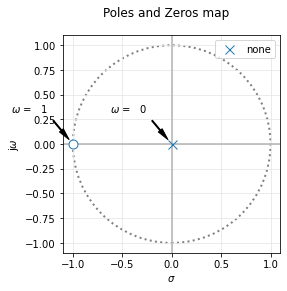

In [1]:
from splane import pzmap, GroupDelay, bodePlot
from scipy.signal import TransferFunction
import matplotlib.pyplot as plt

my_tf = TransferFunction( [1,1], [1,0] )
pzmap(my_tf, 2) #S plane pole/zero plot


$h_2(k) = (1,1,1)$

Esto se traduce en:

$H(z)=1+1.z^{-1}+1.z^{-2} = \frac{1+z+z^2}{z^2}$

(1, <AxesSubplot:xlabel='$\\sigma$', ylabel='j$\\omega$'>)

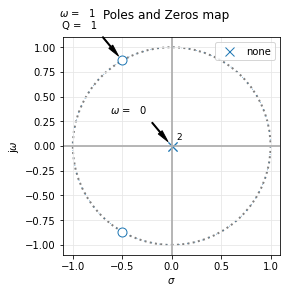

In [2]:
my_tf = TransferFunction( [1,1,1], [1,0,0] )
pzmap(my_tf, 2) #S plane pole/zero plot

Para que la salida represente la media aritmetica deberia ser dividida por la cantidad de muestras.

Filtro diferenciador

$h_1(k) = (1,-1)$

Esto se traduce en:

$H(z)=1-z^{-1} = \frac{z-1}{z}$

(1, <AxesSubplot:xlabel='$\\sigma$', ylabel='j$\\omega$'>)

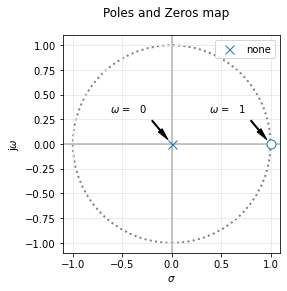

In [3]:
my_tf = TransferFunction( [1,-1], [1,0] )
pzmap(my_tf, 2) #S plane pole/zero plot

$h_2(k) = (1,0,-1)$

Esto se traduce en:

$H(z)=1-z^{-2} = \frac{z^2 -1}{z^2}$

(1, <AxesSubplot:xlabel='$\\sigma$', ylabel='j$\\omega$'>)

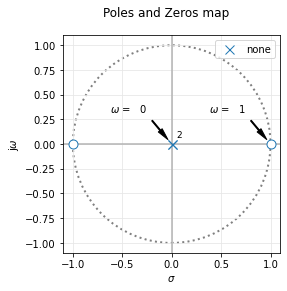

In [4]:
my_tf = TransferFunction( [1,0,-1], [1,0,0] )
pzmap(my_tf, 2) #S plane pole/zero plot